In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
df['Week'] = df['Week'].apply(lambda x: pd.to_datetime(x + '-1', format='%Y-W%U-%w'))
df.set_index('Week', inplace=True)
series = df['Close']
df.head()

,Close
Week,
1971-07-05,890.19
1971-07-12,901.80
1971-07-19,888.51
1971-07-26,887.78
1971-08-02,858.43


# Garch


In [8]:
from math import sqrt
from arch import arch_model

<Axes: xlabel='Week'>

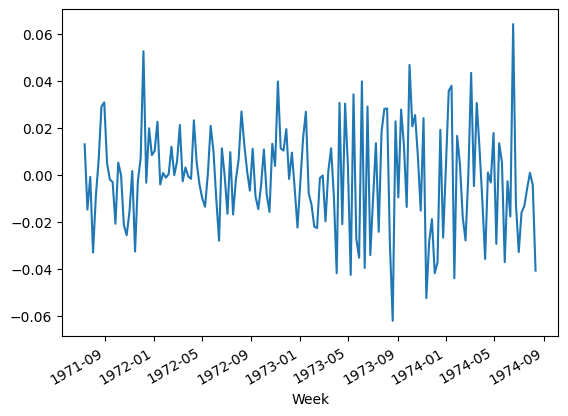

In [122]:
# Приводим ряд к стационарности
returns = series.pct_change().dropna()
returns.plot()

split_date: 1974-05-27 00:00:00
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9522715.91196228
Iteration:      2,   Func. Count:     17,   Neg. LLF: -87.98965167580272
Iteration:      3,   Func. Count:     27,   Neg. LLF: -122.47419385498043
Iteration:      4,   Func. Count:     34,   Neg. LLF: -344.05726497439
Iteration:      5,   Func. Count:     42,   Neg. LLF: -291.4795751469486
Iteration:      6,   Func. Count:     50,   Neg. LLF: -367.81684413157234
Iteration:      7,   Func. Count:     55,   Neg. LLF: -367.8223565713558
Iteration:      8,   Func. Count:     60,   Neg. LLF: -367.8224824700012
Iteration:      9,   Func. Count:     65,   Neg. LLF: -367.8225234876234
Iteration:     10,   Func. Count:     70,   Neg. LLF: -367.8225320046773
Iteration:     11,   Func. Count:     74,   Neg. LLF: -367.82253200443597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -367.8225320046773
            Iterations: 11
            Function evaluatio

<Axes: xlabel='Week'>

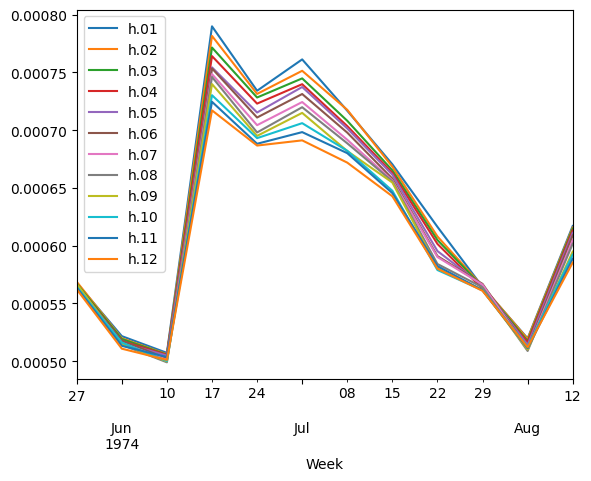

In [84]:
# Применение модели ARCH к симулированному ряду
split_date = returns[-12:].index[0]
print(f'split_date: {split_date}') # split_date

am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(last_obs=split_date) # the model will be estimated the first 150 dates and then forecast for the final 12
print(res.summary())

# Прогноз волатильности
forecast = res.forecast(horizon=12, start=split_date, align='origin', method='simulation')
forecast.variance[split_date:].plot()

Mean squeared error for GARCH model =  0.00078


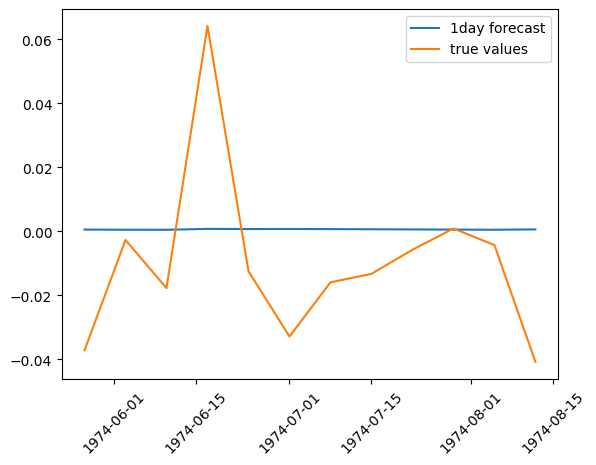

In [94]:
f1 = forecast.variance['h.01'] # Предсказания на 1 день вперед
y_true = returns[split_date:]

plt.plot(f1, label = '1day forecast')
plt.plot(y_true, label = 'true values')
plt.xticks(rotation=45)
plt.legend()

print(f'Mean squeared error for GARCH model =  {mean_squared_error(f1,y_true):.5f}')



In [86]:
# Подготовка данных для обучения и тестирования модели
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # Индекс начала тестовой выборки
    test_index = int(len(data)*(1-test_size))

    # Добавление лагов исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.Close.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    # data = data.drop(["Month"], axis=1)

    # Разделение данных на обучающую и тестовую выборки
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]

    return X_train, X_test, y_train, y_test

In [89]:
X_train, X_test, y_train, y_test = prepareData(returns, lag_start=1, lag_end=20, test_size=0.2)

Mean squeared error for Linear model =  0.00100


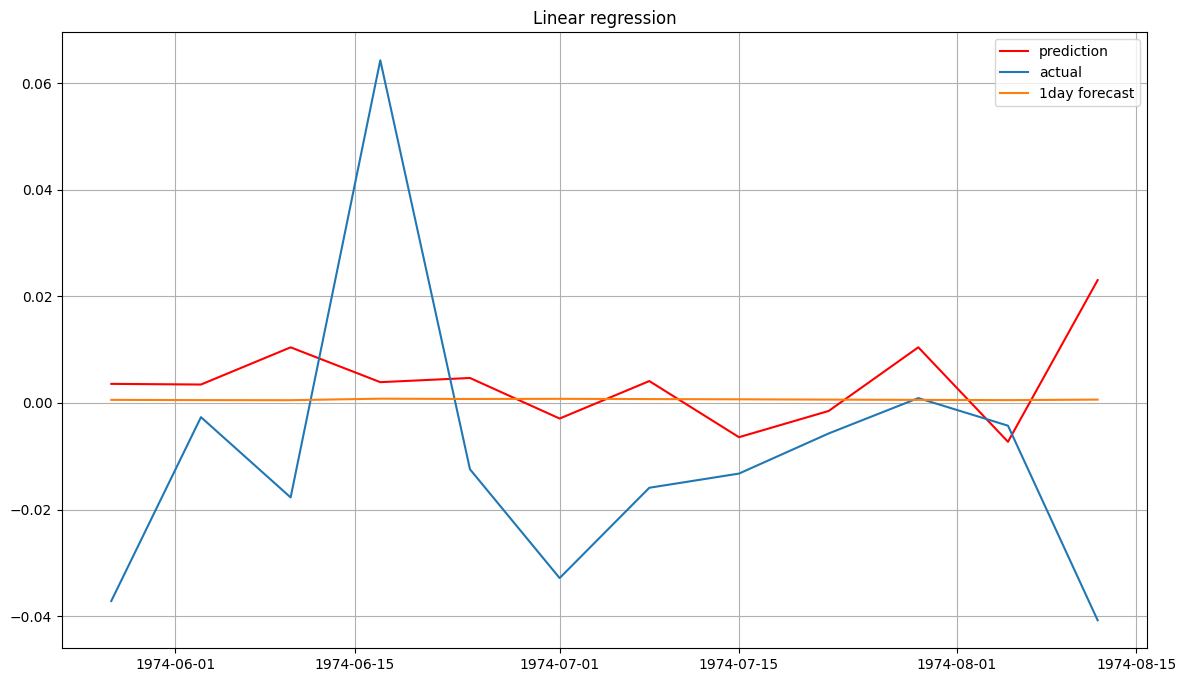

In [121]:
# Обучение модели линейной регрессии
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
prediction = pd.Series(prediction[-len(y_true):]) # Возьмем толко значения для которых мы строили GARCH
prediction.index = pd.Series(y_true).index

# Визуализация прогнозов и фактических значений
plt.figure(figsize=(14, 8))
plt.plot(prediction,  "r", label="prediction")
plt.plot(y_true, label="actual")
plt.plot(f1, label = '1day forecast')
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

print(f'Mean squeared error for Linear model =  {mean_squared_error(prediction,y_true):.5f}')